In [49]:
import os
os.chdir(r"C:\Users\Vincent\Code\Vincent-20-100\backtest_retraites")


## Première partie : constitution du dataset principal

### 🧱 Mise en contexte

Afin de mener à bien l’exercice de backtesting comparatif entre différents systèmes de retraite (par répartition et par capitalisation), il était indispensable de constituer un dataset solide et cohérent retraçant les performances historiques des principaux indices boursiers, depuis 1985.  
L’objectif : simuler un investissement régulier (type DCA) dans des portefeuilles représentatifs sur une très longue période.

Pour cela, les données ont été collectées via l’API `yfinance`, qui fournit les historiques mensuels des indices comme :
- le **CAC 40**,
- le **S&P 500**,
- le **FTSE 100**,

Cependant, cette approche s’est heurtée à plusieurs obstacles :
- **l’absence d’indices en version “Total Return”** (dividendes réinvestis),
- et surtout, **l’absence de données pour les trois premières années du CAC 40 TR et du S&P 500 TR**, deux indices essentiels à l’analyse.

Il a donc fallu reconstruire ces données manquantes à l’aide de méthodes statistiques, tout en garantissant la cohérence économique des résultats.

---

### ⚙️ Choix méthodologique pour le backfilling des valeurs manquantes

Plusieurs approches ont été testées pour combler les données manquantes du **CAC 40 TR** et du **S&P 500 TR** (1985–1987), notamment :
- des modèles de **régression linéaire**,
- des **Random Forest Regressors**,
- et des modèles de séries temporelles : **ARIMA** et **Prophet**.

> 🔬 **Constat** : malgré des scores de validation très élevés (R² proches de 1, faibles écarts-types), les résultats générés étaient souvent incohérents sur le plan économique, avec des **valeurs aberrantes ou des discontinuités non réalistes**.

---

### ✅ Méthode retenue : une approche hybride simple et robuste

Pour garantir la continuité et la crédibilité du dataset, une méthode alternative a été privilégiée. Elle repose sur deux étapes complémentaires :

#### 1. **Méthode par ratio historique**
- Calcul du **ratio moyen de performance** entre :
  - `S&P 500 PR` et `S&P 500 TR` (≈ 0.99),
  - `S&P 500 PR` et `CAC 40 TR` (≈ 0.83).
- Application de ce ratio aux valeurs du `S&P 500 PR` avant 1988, afin d’estimer les valeurs manquantes du `TR`.

> Avantage : cohérence structurelle, variation réaliste.  
> Inconvénient : **volatilité exagérée** lors de fortes hausses de marché (Les dividendes ne sont pas ou peu soumises aux fluctuations du marché).

#### 2. **Méthode par rendement mensuel moyen**
- Calcul de la **performance mensuelle moyenne composée** sur la période connue.
- Application de ce rendement à une base 1, puis remise à l’échelle sur la valeur connue de 1988.

> Avantage : continuité parfaite, aucun saut.  
> Inconvénient : **lissage excessif**, perte de la volatilité naturelle des marchés.

---

### 🧪 Méthode finale : une hybridation des deux approches

> Un **moyenne non pondérée** des deux méthodes a été utilisée, permettant :
> - d’atténuer la volatilité exagérée de la méthode par ratio,
> - d’éviter le caractère trop lisse de la méthode par performance moyenne.

Ce choix méthodologique permet :
- une reconstitution **sans discontinuité ni valeurs aberrantes**,
- une trajectoire crédible et économiquement interprétable,
- et une cohérence avec les performances long terme connues des indices étudiés.

ℹ️ À noter : le backfill ne concerne que les 3 premières années de la période étudiée (1985–1987). Étant donné le poids très faible de ces années dans l’accumulation totale du capital sur 40 ans (du fait des effets des intérêts composés), l’impact de ces approximations est considéré comme très limité sur les résultats finaux.

---

### 🎯 Conclusion

Ce compromis méthodologique ne vise pas la précision absolue, mais la **robustesse sur 40 ans de simulation**, dans le cadre d’un modèle de retraite capitalisé.  
Il constitue une **base fiable** pour les calculs à venir, tout en restant **simple, explicable, et reproductible**.

L’analyse du portefeuille simulé sera détaillée dans un second notebook, sur la base de ce dataset désormais reconstitué.


In [50]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Définition des dates de début et de fin
start_date = "1980-01-01"
end_date = "2024-12-31"

# Pour évité de répéter les appels API, les données utiles on été éxtraites puis stocker sur la machine
'''# Téléchargement des données historiques du CAC 40 et du S&P 500 depuis Yahoo Finance
CAC40 = yf.download("^FCHI", start=start_date, end=end_date, interval="1mo")["Open"]         # Indice CAC40 PR
CAC40_TR = yf.download("PX1GR.PA", start=start_date, end=end_date, interval="1mo")["Open"]   # Indice CAC40 TR
sp500 = yf.download("^GSPC", start=start_date, end=end_date, interval="1mo")["Open"]         # Indice CAC40 PR
sp500_TR = yf.download("^SP500TR", start=start_date, end=end_date, interval="1mo")["Open"]   # Indice sp500 TR
FTSE100 = yf.download("^FTSE", start=start_date, end=end_date, interval="1mo")["Open"]       # Indice FTSE100 PR

# Garder uniquement les prix d'ouverture et renommer
CAC40 = CAC40[['^FCHI']].rename(columns={'^FCHI': "CAC40"})
CAC40_TR = CAC40_TR[['PX1GR.PA']].rename(columns={'PX1GR.PA': "CAC40_TR"})
sp500 = sp500[['^GSPC']].rename(columns={'^GSPC': "SP500_PR"})
sp500_TR = sp500_TR[['^SP500TR']].rename(columns={'^SP500TR': "SP500_TR"})
FTSE100 = FTSE100[['^FTSE']].rename(columns={'^FTSE': "FTSE100_PR"})'''

# Importer et convertir les data de yahoo finance
CAC40 = pd.read_csv(r"data\raw\CAC40.csv",
                    index_col='Date', parse_dates=['Date'])         # Indice CAC40 PR   = Price Return = Dividendes non réinvestis
CAC40_TR = pd.read_csv(r"data\raw\CAC40_TR.csv",
                       index_col='Date', parse_dates=['Date'])   # Indice CAC40 TR   = Total Return = Dividendes réinvestis
sp500 = pd.read_csv(r"data\raw\sp500.csv",
                    index_col='Date', parse_dates=['Date'])         # Indice CAC40 PR   = Price Return = Dividendes non réinvestis
sp500_TR = pd.read_csv(r"data\raw\sp500_TR.csv",
                       index_col='Date', parse_dates=['Date'])   # Indice sp500 TR   = Total Return = Dividendes réinvestis
FTSE100 = pd.read_csv(r"data\raw\FTSE100.csv",
                      index_col='Date', parse_dates=['Date'])       # Indice FTSE100 PR = Price Return = Dividendes non réinvestis


# Importer, renommer et convertir le fichier du World Government Bond Index
WGBI = pd.read_csv(r"data\raw\WGBI.csv")   
WGBI.rename(columns={"FTSE World Government Bond - Developed Markets": "WGBI_TR"}, inplace=True)
WGBI["Date"] = pd.to_datetime(WGBI["Date"], format="%m/%Y")
WGBI = WGBI[WGBI["Date"] <= pd.to_datetime(end_date)]
WGBI.set_index("Date", inplace=True)

# Importer, renommer et convertir le CAC 40 Gross Revenue 2015/2025 (le cac50 Total Return de yahou finance s'arrete en 2015)
CAC40_TR_ = pd.read_csv(r"data\raw\CAC40GROSSTR_2025-03-21_X.csv")   
CAC40_TR_.rename(columns={"ouv": "CAC40_TR_"}, inplace=True)
CAC40_TR_["Date"] = pd.to_datetime(CAC40_TR_["date"], format="%d/%m/%Y")
CAC40_TR_ = CAC40_TR_.drop(columns=["date","haut","bas","clot","vol","devise"])
CAC40_TR_ = CAC40_TR_[CAC40_TR_["Date"] <= pd.to_datetime(end_date)]
CAC40_TR_.set_index("Date", inplace=True)
CAC40_TR_ = CAC40_TR_.resample("MS").first()

# Fusionner les indices sur la base des dates
df = pd.concat([CAC40_TR, CAC40_TR_, sp500_TR, sp500, FTSE100, WGBI["WGBI_TR"]], axis=1, join="outer")

# Confirmation que l’index est bien en datetime
df.index = pd.to_datetime(df.index)

### 🔄 Fusion de deux sources de données partiellement redondantes

Les données disponibles pour le CAC 40 TR provenaient de deux sources différentes, partiellement redondantes mais avec de légères divergences dans les valeurs communes.

Ces écarts sont dus à des différences d'arrondis ou de méthode d’agrégation (par exemple, lors du passage à des performances mensuelles). Il a donc été nécessaire de fusionner proprement ces deux colonnes, tout en corrigeant leur écart moyen.

Pour cela, les étapes suivantes ont été suivies :
    - Identification des dates communes aux deux colonnes. \
    - Calcul d’un ratio moyen de décalage, colonne par colonne.\
    - Correction de l’une des colonnes à l’aide de ce ratio moyen. \
    - Fusion finale via la méthode combine_first() de pandas, permettant de garder les valeurs existantes et de compléter avec les valeurs corrigées.

Ce processus a permis d’obtenir une série homogène et cohérente du CAC 40 TR sur toute la période étudiée.



In [51]:
# Problème de qualité des données, les valeur communes ne sont pas strictement identiques, 
# cela est du à des aproximation du passage aux perf mensuels

# # Filtrer les lignes où les deux colonnes ne sont pas nulles
df_common = df[df["CAC40_TR"].notna() & df["CAC40_TR_"].notna()]
df_common = df_common.drop(columns=["SP500_TR","SP500_PR","FTSE100_PR","WGBI_TR"])
df_common["ratio_TR"] = df_common["CAC40_TR_"] / df_common["CAC40_TR"]
# Affichage pour vérification
df_common

,CAC40_TR,CAC40_TR_,ratio_TR
Date,,,
2015-03-01,11337.700195,11723.71,1.034047
2015-04-01,11692.099609,11570.65,0.989613
2015-05-01,11712.099609,11744.58,1.002773
2015-06-01,11819.400391,11828.24,1.000748
2015-07-01,11542.500000,11462.72,0.993088
2015-08-01,12111.400391,12007.99,0.991462
2015-09-01,10741.099609,10847.90,1.009943
2015-10-01,10485.400391,10702.10,1.020667
2015-11-01,11654.900391,11495.24,0.986301


In [52]:
# Calcul du ratio, puis application sur le plus petit des deux jeux de données
mean_ratio = df_common["ratio_TR"].mean()
print(f"Différence moyenne entre les valeur communes de {1-mean_ratio}")

CAC40_TR_scaled = df["CAC40_TR_"] / mean_ratio
df["CAC40_TR_fusion"] = df["CAC40_TR"].combine_first(CAC40_TR_scaled)
df = df.drop(columns=["CAC40_TR","CAC40_TR_"])
df["CAC40_TR"] = df["CAC40_TR_fusion"]
df = df.drop(columns=["CAC40_TR_fusion"])
print(f"Fusion des deux datasets complémentaires réussie !")

Différence moyenne entre les valeur communes de -0.003796854033220054
Fusion des deux datasets complémentaires réussie !


### ↔️ Division du DataSet :

Avant de procéder au backfill, il est nécessaire de scinder notre dataset en deux parties distinctes :
- La **partie complète**, contenant les données disponibles et fiables.
- La **partie incomplète**, correspondant à la période pour laquelle les valeurs sont manquantes et doivent être reconstruites.

Cette séparation permettra d’appliquer nos méthodes de projection uniquement là où cela est nécessaire, tout en préservant l’intégrité des données historiques existantes.


In [53]:
# Définir la dernière date avec des Null, puis diviser les DF en deux (partie complète et partie incomplète)
last_nan_date = df[df.isna().any(axis=1)].index.max()                 # Trouver la dernière date avec au moins un NaN
first_full_date = df[df.index > last_nan_date].dropna().index[0]      # Récupérer la suivante
from datetime import datetime
print("Première date complète après les NaN :", first_full_date)

# Définir la période connue
start_known = first_full_date
end_known = df.index.max()

df_known = df[df.index >= first_full_date]         # DataFrame sans valeur manquantes
df_to_predict = df[df.index < first_full_date]     # DataFrame à remplir avec le modèle de prédiction

Première date complète après les NaN : 1988-01-01 00:00:00


In [54]:
# Confirmation de la corrélation entre les indice choisis
df_known[["SP500_TR","SP500_PR","CAC40_TR"]].corr()

,SP500_TR,SP500_PR,CAC40_TR
SP500_TR,1.000000,0.996776,0.968203
SP500_PR,0.996776,1.000000,0.978621
CAC40_TR,0.968203,0.978621,1.000000


### 🔀 Calcul des rendements et ratios :

Après avoir confirmé une forte corrélation entre nos indices de référence, nous allons maintenant calculer les rendements mensuels et les ratios historiques nécessaires à la reconstruction des données manquantes (backfill).
Ces métriques constitueront la base des deux méthodes de projection utilisées par la suite.

In [55]:
# Calcul des rendements mensuels moyens
mean_sp500_pr = df['SP500_PR'].pct_change().dropna().mean()
mean_sp500_tr = df_known['SP500_TR'].pct_change().dropna().mean()
mean_cac40_tr = df_known['CAC40_TR'].pct_change().dropna().mean()

# Ratio des rendements moyennes
mean_ratio_snp_pr_tr = mean_sp500_tr / mean_sp500_pr
mean_ratio_snp_cac = mean_cac40_tr / mean_sp500_pr

print(f"Moyenne des rendements mensuels du SNP500 PR : {mean_sp500_pr}")
print(f"Moyenne des rendements mensuels du SNP500 TR : {mean_sp500_tr}")
print(f"Moyenne des rendements mensuels du CAC40 TR : {mean_cac40_tr}")
print()
print(f"Ratio des moyennes mensuelles SNP500 TR / SNP500 PR : {mean_ratio_snp_pr_tr}")
print(f"Ratio des moyennes mensuelles CAC40 TR / SNP500 PR : {mean_ratio_snp_cac}")
print()
#Calcul du rendement perdiode avant "first_full_date" (vérification)
mean_sp500_before = mean_sp500_pr = df_known['SP500_PR'].pct_change().dropna().mean()
print(f"Moyenne des rendements mensuels du SNP500 PR (avant {first_full_date}) : {mean_sp500_before}")

Moyenne des rendements mensuels du SNP500 PR : 0.008524919373678625
Moyenne des rendements mensuels du SNP500 TR : 0.009916236655870332
Moyenne des rendements mensuels du CAC40 TR : 0.008664828732149785

Ratio des moyennes mensuelles SNP500 TR / SNP500 PR : 1.1632059168192852
Ratio des moyennes mensuelles CAC40 TR / SNP500 PR : 1.0164118101695063

Moyenne des rendements mensuels du SNP500 PR (avant 1988-01-01 00:00:00) : 0.008176950480208047


### ⤴️ Backfill hybride :

Nous allons désormais procéder au backfill proprement dit, en appliquant successivement les deux méthodes décrites précédemment, puis en les fusionnant par une moyenne simple afin d’obtenir une estimation robuste et équilibrée.

In [56]:
# Création de la colonne de variation mensuelle de référence (S&P 500 Price Return)
df['SP500_PR_var_m'] = df['SP500_PR'].pct_change()

# Création des colonnes de variations mensuels estimés (avec le ratio)
df['SP500_TR_var_estimated'] = df['SP500_PR_var_m'] * mean_ratio_snp_pr_tr
df['CAC40_TR_var_estimated'] = df['SP500_PR_var_m'] * mean_ratio_snp_cac

# Initialiser des première valeur connue :
df['SP500_TR_estimated'] = df['SP500_TR']  # Copie de la vraie colonne
df.loc[first_full_date, 'SP500_TR_estimated'] = df.loc[first_full_date, 'SP500_TR']
df['CAC40_TR_estimated'] = df['CAC40_TR']  # Copie de la vraie colonne
df.loc[first_full_date, 'CAC40_TR_estimated'] = df.loc[first_full_date, 'CAC40_TR']

In [57]:
# Création d'une base 1 pour simuler l'évolution relative du CAC40 estimé
df['SP500_base1'] = np.nan
df.loc[df.index.min(), 'SP500_base1'] = 1
df['CAC40_base1'] = np.nan
df.loc[df.index.min(), 'CAC40_base1'] = 1

for i in range(1, len(df.loc[:first_full_date])):
    prev_idx = df.index.get_loc(df.index.min()) + i - 1
    curr_idx = prev_idx + 1
    df.iloc[curr_idx, df.columns.get_loc('SP500_base1')] = (
        df.iloc[prev_idx, df.columns.get_loc('SP500_base1')] * (1 + df.iloc[curr_idx]['SP500_TR_var_estimated'])
    )
    df.iloc[curr_idx, df.columns.get_loc('CAC40_base1')] = (
        df.iloc[prev_idx, df.columns.get_loc('CAC40_base1')] * (1 + df.iloc[curr_idx]['CAC40_TR_var_estimated'])
    )
# Remise à l'échelle sur les valeurs connues
scaling_factor = df.loc[first_full_date, 'SP500_TR'] / df.loc[first_full_date, 'SP500_base1']
df['SP500_TR_ratio'] = df['SP500_base1'] * scaling_factor
scaling_factor = df.loc[first_full_date, 'CAC40_TR'] / df.loc[first_full_date, 'CAC40_base1']
df['CAC40_TR_ratio'] = df['CAC40_base1'] * scaling_factor

df['SP500_TR_ratio'] = df['SP500_TR'].combine_first(df['SP500_TR_ratio'])
df['CAC40_TR_ratio'] = df['CAC40_TR'].combine_first(df['CAC40_TR_ratio'])

df = df.drop(columns=["SP500_TR_var_estimated","CAC40_TR_var_estimated","SP500_TR_estimated",
                      "CAC40_TR_estimated","SP500_base1","CAC40_base1"])

In [58]:
# Création de nouvelles colonnes pour stocker les résultats du backfilling
df['SP500_TR_mean_perf'] = df['SP500_TR'].copy()
df['CAC40_TR_mean_perf'] = df['CAC40_TR'].copy()

# Backfilling du SNP500 TR en appliquant le rendement mensuel à l'envers depuis 1988-01-01
for i in range(len(df.loc[:last_nan_date])):
    current_date = df.index.get_loc(first_full_date) - i
    prev_date = current_date - 1
    if prev_date >= 0:
        df.iloc[prev_date, df.columns.get_loc('SP500_TR_mean_perf')] = df.iloc[
            current_date, df.columns.get_loc('SP500_TR_mean_perf')] / (1 + mean_sp500_tr)

# Backfilling du CAC40 TR en appliquant le rendement mensuel à l'envers depuis 1988-01-01
for i in range(len(df.loc[:last_nan_date])):
    current_date = df.index.get_loc(first_full_date) - i
    prev_date = current_date - 1
    if prev_date >= 0:
        df.iloc[prev_date, df.columns.get_loc('CAC40_TR_mean_perf')] = df.iloc[
            current_date, df.columns.get_loc('CAC40_TR_mean_perf')] / (1 + mean_cac40_tr)


In [59]:
# Calcul de la moyenne des deux méthodes
df['SP500_TR_combined'] = df[['SP500_TR_ratio', 'SP500_TR_mean_perf']].mean(axis=1)
df['CAC40_TR_combined'] = df[['CAC40_TR_ratio', 'CAC40_TR_mean_perf']].mean(axis=1)


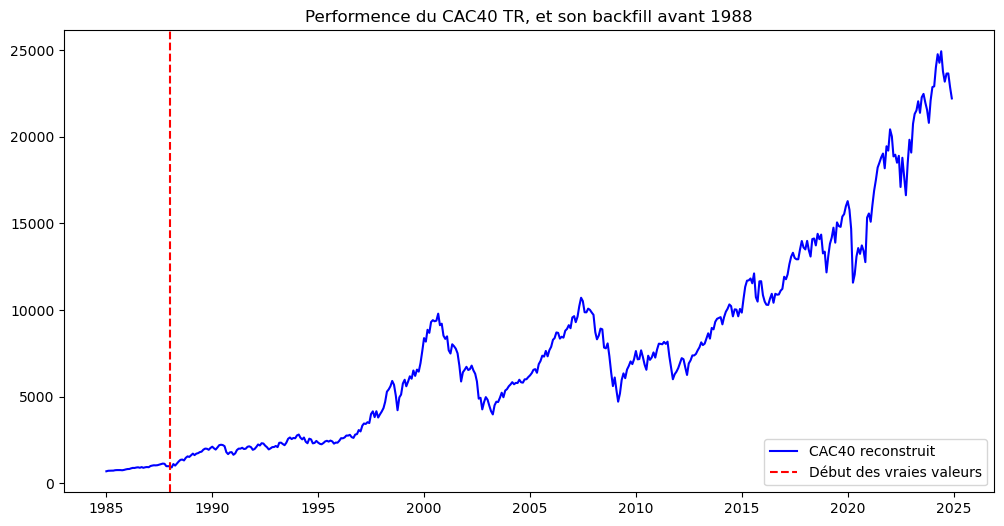

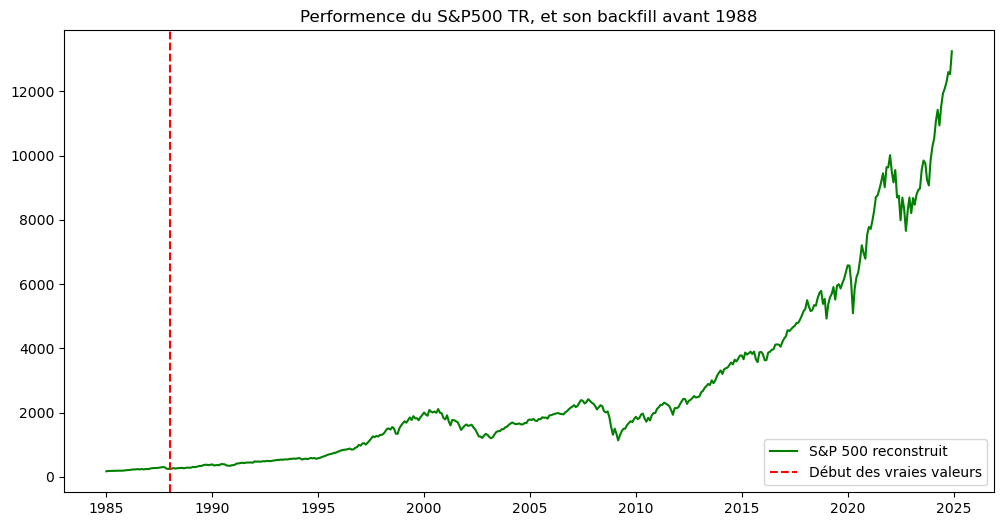

In [65]:
# Afichage du CAC 40 avec le backfill
plt.figure(figsize=(12,6))
plt.plot(df.index, df["CAC40_TR_combined"], label="CAC40 reconstruit", color="blue")
plt.axvline(x=pd.to_datetime(first_full_date), color="red", linestyle="--", label="Début des vraies valeurs")
plt.legend()
plt.title("Performence du CAC40 TR, et son backfill avant 1988")
plt.savefig("charts/CAC40_TR_perf.png", dpi=300, bbox_inches='tight')
plt.show()

# Afichage du S&P500 avec le backfill
plt.figure(figsize=(12,6))
plt.plot(df.index, df["SP500_TR_combined"], label="S&P 500 reconstruit", color="green")
plt.axvline(x=pd.to_datetime(first_full_date), color="red", linestyle="--", label="Début des vraies valeurs")
plt.legend()
plt.title("Performence du S&P500 TR, et son backfill avant 1988")
plt.savefig("charts/S&P500_TR_perf.png", dpi=300, bbox_inches='tight')
plt.show()

# Sauvegarde dans le dossier 'charts'



In [61]:
df_to_export = df[["SP500_TR_combined","CAC40_TR_combined","WGBI_TR"]].rename(
    columns={'SP500_TR_combined': 'SP500_TR',"CAC40_TR_combined": "CAC40_TR"})

print(df_to_export)

df_to_export.to_csv(r"data\processed\DataFrame_backfilled.csv", index=True, encoding="utf-8")

                SP500_TR      CAC40_TR       WGBI_TR
Date                                                
1985-01-01    172.176132    692.288669  10000.000000
1985-02-01    180.194935    720.457778  10235.623791
1985-03-01    181.992612    726.738050   9832.991278
1985-04-01    182.598183    728.870481  10019.526779
1985-05-01    183.032920    730.405192  10250.878162
...                  ...           ...           ...
2024-08-01  12086.490234  23179.092370  55630.313495
2024-09-01  12292.099609  23646.248645  56093.077188
2024-10-01  12598.030273  23654.766305  55534.603307
2024-11-01  12533.190430  22857.802261  57289.947892
2024-12-01  13245.660156  22211.844867  56892.306595

[480 rows x 3 columns]


In [62]:
# Récupérer la valeur final des indices base 1 (coefficient multiplicateur) :
SP500_TR_final = df_to_export["SP500_TR"].iloc[-1] / df_to_export["SP500_TR"].iloc[0]
CAC40_TR_final = df_to_export["CAC40_TR"].iloc[-1] / df_to_export["CAC40_TR"].iloc[0]
WGBI_TR_final =  df_to_export["WGBI_TR"].iloc[-1] / df_to_export["WGBI_TR"].iloc[0]
print(f"Coefficient multiplicateur du S&P500, CAC40 et WGBI (TR) en 40 ans : {
    int(SP500_TR_final), int(CAC40_TR_final), int(WGBI_TR_final)}")
print()

# Calcul du rendement annualisé :
nb_years = len(df_to_export) / 12
annual_return_sp = (SP500_TR_final) ** (1 / nb_years) - 1
annual_return_cac = (CAC40_TR_final) ** (1 / nb_years) - 1
annual_return_wgbi = (WGBI_TR_final) ** (1 / nb_years) - 1
print(f"Rendement annualisé du S&P500, CAC40 et WGBI (TR) sur la période : {
    round(annual_return_sp*100,2), round(annual_return_cac*100,2), round(annual_return_wgbi*100,2)} %")

Coefficient multiplicateur du S&P500, CAC40 et WGBI (TR) en 40 ans : (76, 32, 5)

Rendement annualisé du S&P500, CAC40 et WGBI (TR) sur la période : (11.47, 9.06, 4.44) %


### 🎯 Mission accomplie :

Le dataset est désormais reconstruit sur toute la période cible.  
Nous pouvons désormais passer à l’étape de backtesting dans le second notebook !